Notebook de test 

Similarité calculé sur 768 dimensions brutes

## Out-Of-Distribution (OOD) Robustness Testing

### Phase 1: Characterization of generated embedding & similarity measurement
Evaluate how far the generated embedding are close to each other. 

Plot a similarity matrix of the generated embedding to visualize the relationships between different products.

Plot a histogram of the mean similarity scores to understand the distribution of similarities across products.

### Phase 2: OOD Robustness Testing on special cases (hypothesis testing)
Select one with the highest similarity score with one of the product in the training set and one with the lowest similarity score.

Evaluate the performance of the model on these two products when they are excluded from the training set.

Visualize the prediction vs the actual values for these two products.

In [7]:
import sys
sys.path.insert(0, '../')
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
DATA_DIR = '../data/'

# ===== Charger les 3 versions d'embeddings =====
versions = {
    'IA_only': {
        'embeddings': np.load(DATA_DIR + 'embeddings_IA_only_all.npy'),
        'data': pd.read_excel(DATA_DIR + 'data_IA_only_with_embeddings_index.xlsx'),
    },
    'Feedtable_only': {
        'embeddings': np.load(DATA_DIR + 'embeddings_Feedtable_only_all.npy'),
        'data': pd.read_excel(DATA_DIR + 'data_Feedtable_only_with_embeddings_index.xlsx'),
    },
    'Combined': {
        'embeddings': np.load(DATA_DIR + 'embeddings_combined_all.npy'),
        'data': pd.read_excel(DATA_DIR + 'data_combined_with_embeddings_index.xlsx'),
    }
}
for version_name, data in versions.items():
    print(f"  - {version_name}: embeddings {data['embeddings'].shape}, data {data['data'].shape}")


  - IA_only: embeddings (6352, 768), data (6352, 28)
  - Feedtable_only: embeddings (122, 768), data (122, 28)
  - Combined: embeddings (6550, 768), data (6550, 28)


In [12]:
# ===== Calcul des similarités pour chaque version =====

similarity_results = {}

for version_name, data in versions.items():
    print(f"\n{'='*70}")
    print(f" Analyse {version_name}")
    print(f"{'='*70}")
    
    embeddings = data['embeddings']
    df_version = data['data'].copy()
    
    print(f"  Avant drop_duplicates:")
    print(f"    - df_version shape: {df_version.shape}")
    print(f"    - embeddings shape: {embeddings.shape}")
    
    # Garder seulement les colonnes pertinentes
    # drop_duplicates sur [Nom, Definition] pour garder un seul exemplaire par produit unique
    df_version = df_version[['Nom', 'embedding_idx', 'Definition', 'source']].drop_duplicates(
        subset=['Nom', 'Definition'], keep='first'
    )
    
    print(f"  Après drop_duplicates (produits uniques):")
    print(f"    - df_version shape: {df_version.shape}")
    
    # IMPORTANT: Les embedding_idx pointent directement aux lignes du fichier embeddings
    # Il suffit de les utiliser comme indices pour accéder aux bonnes lignes
    original_embedding_indices = df_version['embedding_idx'].values.astype(int)
    filtered_embeddings = embeddings[original_embedding_indices]
    
    print(f"    - filtered_embeddings shape: {filtered_embeddings.shape}")
    
    # Vérifier l'alignement
    assert len(df_version) == filtered_embeddings.shape[0], f"Mismatch: {len(df_version)} vs {filtered_embeddings.shape[0]}"
    print(f"   Alignment check passed")
    
    # Calculer la matrice de similarité avec les embeddings filtrés
    similarity_matrix = cosine_similarity(filtered_embeddings)
    
    # Exclure la diagonale
    np.fill_diagonal(similarity_matrix, np.nan)
    
    # Moyenne des similarités pour chaque produit
    mean_similarity = np.nanmean(similarity_matrix, axis=1)
    
    # Créer liste des paires
    noms = df_version['Nom'].tolist()
    definitions = df_version['Definition'].tolist()
    source = df_version['source'].tolist()
    
    # Garder uniquement la partie supérieure de la matrice
    triu_indices = np.triu_indices_from(similarity_matrix, k=1)
    
    pairs = [
        (noms[i], noms[j], similarity_matrix[i, j], definitions[i], definitions[j], source[i], source[j])
        for i, j in zip(*triu_indices)
    ]
    
    pairs_df = pd.DataFrame(pairs, columns=["Nom_1", "Nom_2", "Similarity", "Definition_1", "Definition_2", "Source_1", "Source_2"])
    
    # Trier par similarité
    pairs_sorted = pairs_df.sort_values("Similarity", ascending=False)
    
    # Stocker les résultats
    similarity_results[version_name] = {
        'similarity_matrix': similarity_matrix,
        'pairs_df': pairs_df,
        'pairs_sorted': pairs_sorted,
        'mean_similarity': mean_similarity,
        'noms': noms,
        'definitions': definitions,
        'source': source,
    }
    
    print(f"\n✓ {version_name}:")
    print(f"  - Produits uniques: {len(noms)}")
    print(f"  - Similarité moyenne: {np.nanmean(mean_similarity):.4f} ± {np.nanstd(mean_similarity):.4f}")
    print(f"  - Min similarity (most isolated): {np.nanmin(mean_similarity):.4f}")
    print(f"  - Max similarity (most connected): {np.nanmax(mean_similarity):.4f}")
    
    # Top 5 similaires
    print(f"\n  Top 5 paires les plus similaires:")
    for idx, row in pairs_sorted.head(5).iterrows():
        print(f"    {row['Nom_1']} <-> {row['Nom_2']}: {row['Similarity']:.4f}")



 Analyse IA_only
  Avant drop_duplicates:
    - df_version shape: (6352, 28)
    - embeddings shape: (6352, 768)
  Après drop_duplicates (produits uniques):
    - df_version shape: (73, 4)
    - filtered_embeddings shape: (73, 768)
   Alignment check passed

✓ IA_only:
  - Produits uniques: 73
  - Similarité moyenne: 0.3929 ± 0.0928
  - Min similarity (most isolated): 0.0715
  - Max similarity (most connected): 0.5262

  Top 5 paires les plus similaires:
    Drêches de blé de distillerie, amidon < 7 %  <-> Drêches de blé de distillerie, amidon > 7 % : 0.9853
    Tourteau de tournesol, huile < 5 %, décortiqué  <-> Tourteau de tournesol, huile < 5 %, non décortiqué : 0.9812
    Tourteau de germes de maïs, huile < 5 %  <-> Tourteau de germes de maïs, huile 5-20 % : 0.9751
    Tourteau de colza, huile < 5 %  <-> Tourteau de colza, huile 5-20 % : 0.9680
    Son de riz, huile < 5 % <-> Son de riz, huile > 5 %: 0.9299

 Analyse Feedtable_only
  Avant drop_duplicates:
    - df_version shape: 

In [13]:
# Créer des mappings Nom -> embedding pour chaque version
nom_to_embedding_map = {}

for version_name, data in versions.items():
    df_version = data['data'].copy()
    embeddings = data['embeddings']
    
    df_version = df_version[['Nom', 'embedding_idx', 'Definition', 'source']].drop_duplicates(
        subset=['Nom', 'Definition'], keep='first'
    )
    
    # Utiliser les indices ORIGINAUX pour accéder aux embeddings
    original_embedding_indices = df_version['embedding_idx'].values.astype(int)
    filtered_embeddings = embeddings[original_embedding_indices]
    
    # Créer le mapping avec les noms et embeddings filtrés
    nom_to_embedding = dict(zip(
        df_version['Nom'].tolist(),
        filtered_embeddings
    ))
    
    nom_to_embedding_map[version_name] = nom_to_embedding
    print(f"✓ {version_name}: mapping créé ({len(nom_to_embedding)} produits)")


✓ IA_only: mapping créé (73 produits)
✓ Feedtable_only: mapping créé (122 produits)
✓ Combined: mapping créé (261 produits)


## 2. Heatmaps de Similarité - Comparaison des 3 versions

Visualiser les matrices de similarité pour chaque version


SIMILARITY MATRICES - HEATMAPS

IA_only - Similarity Matrix Heatmap


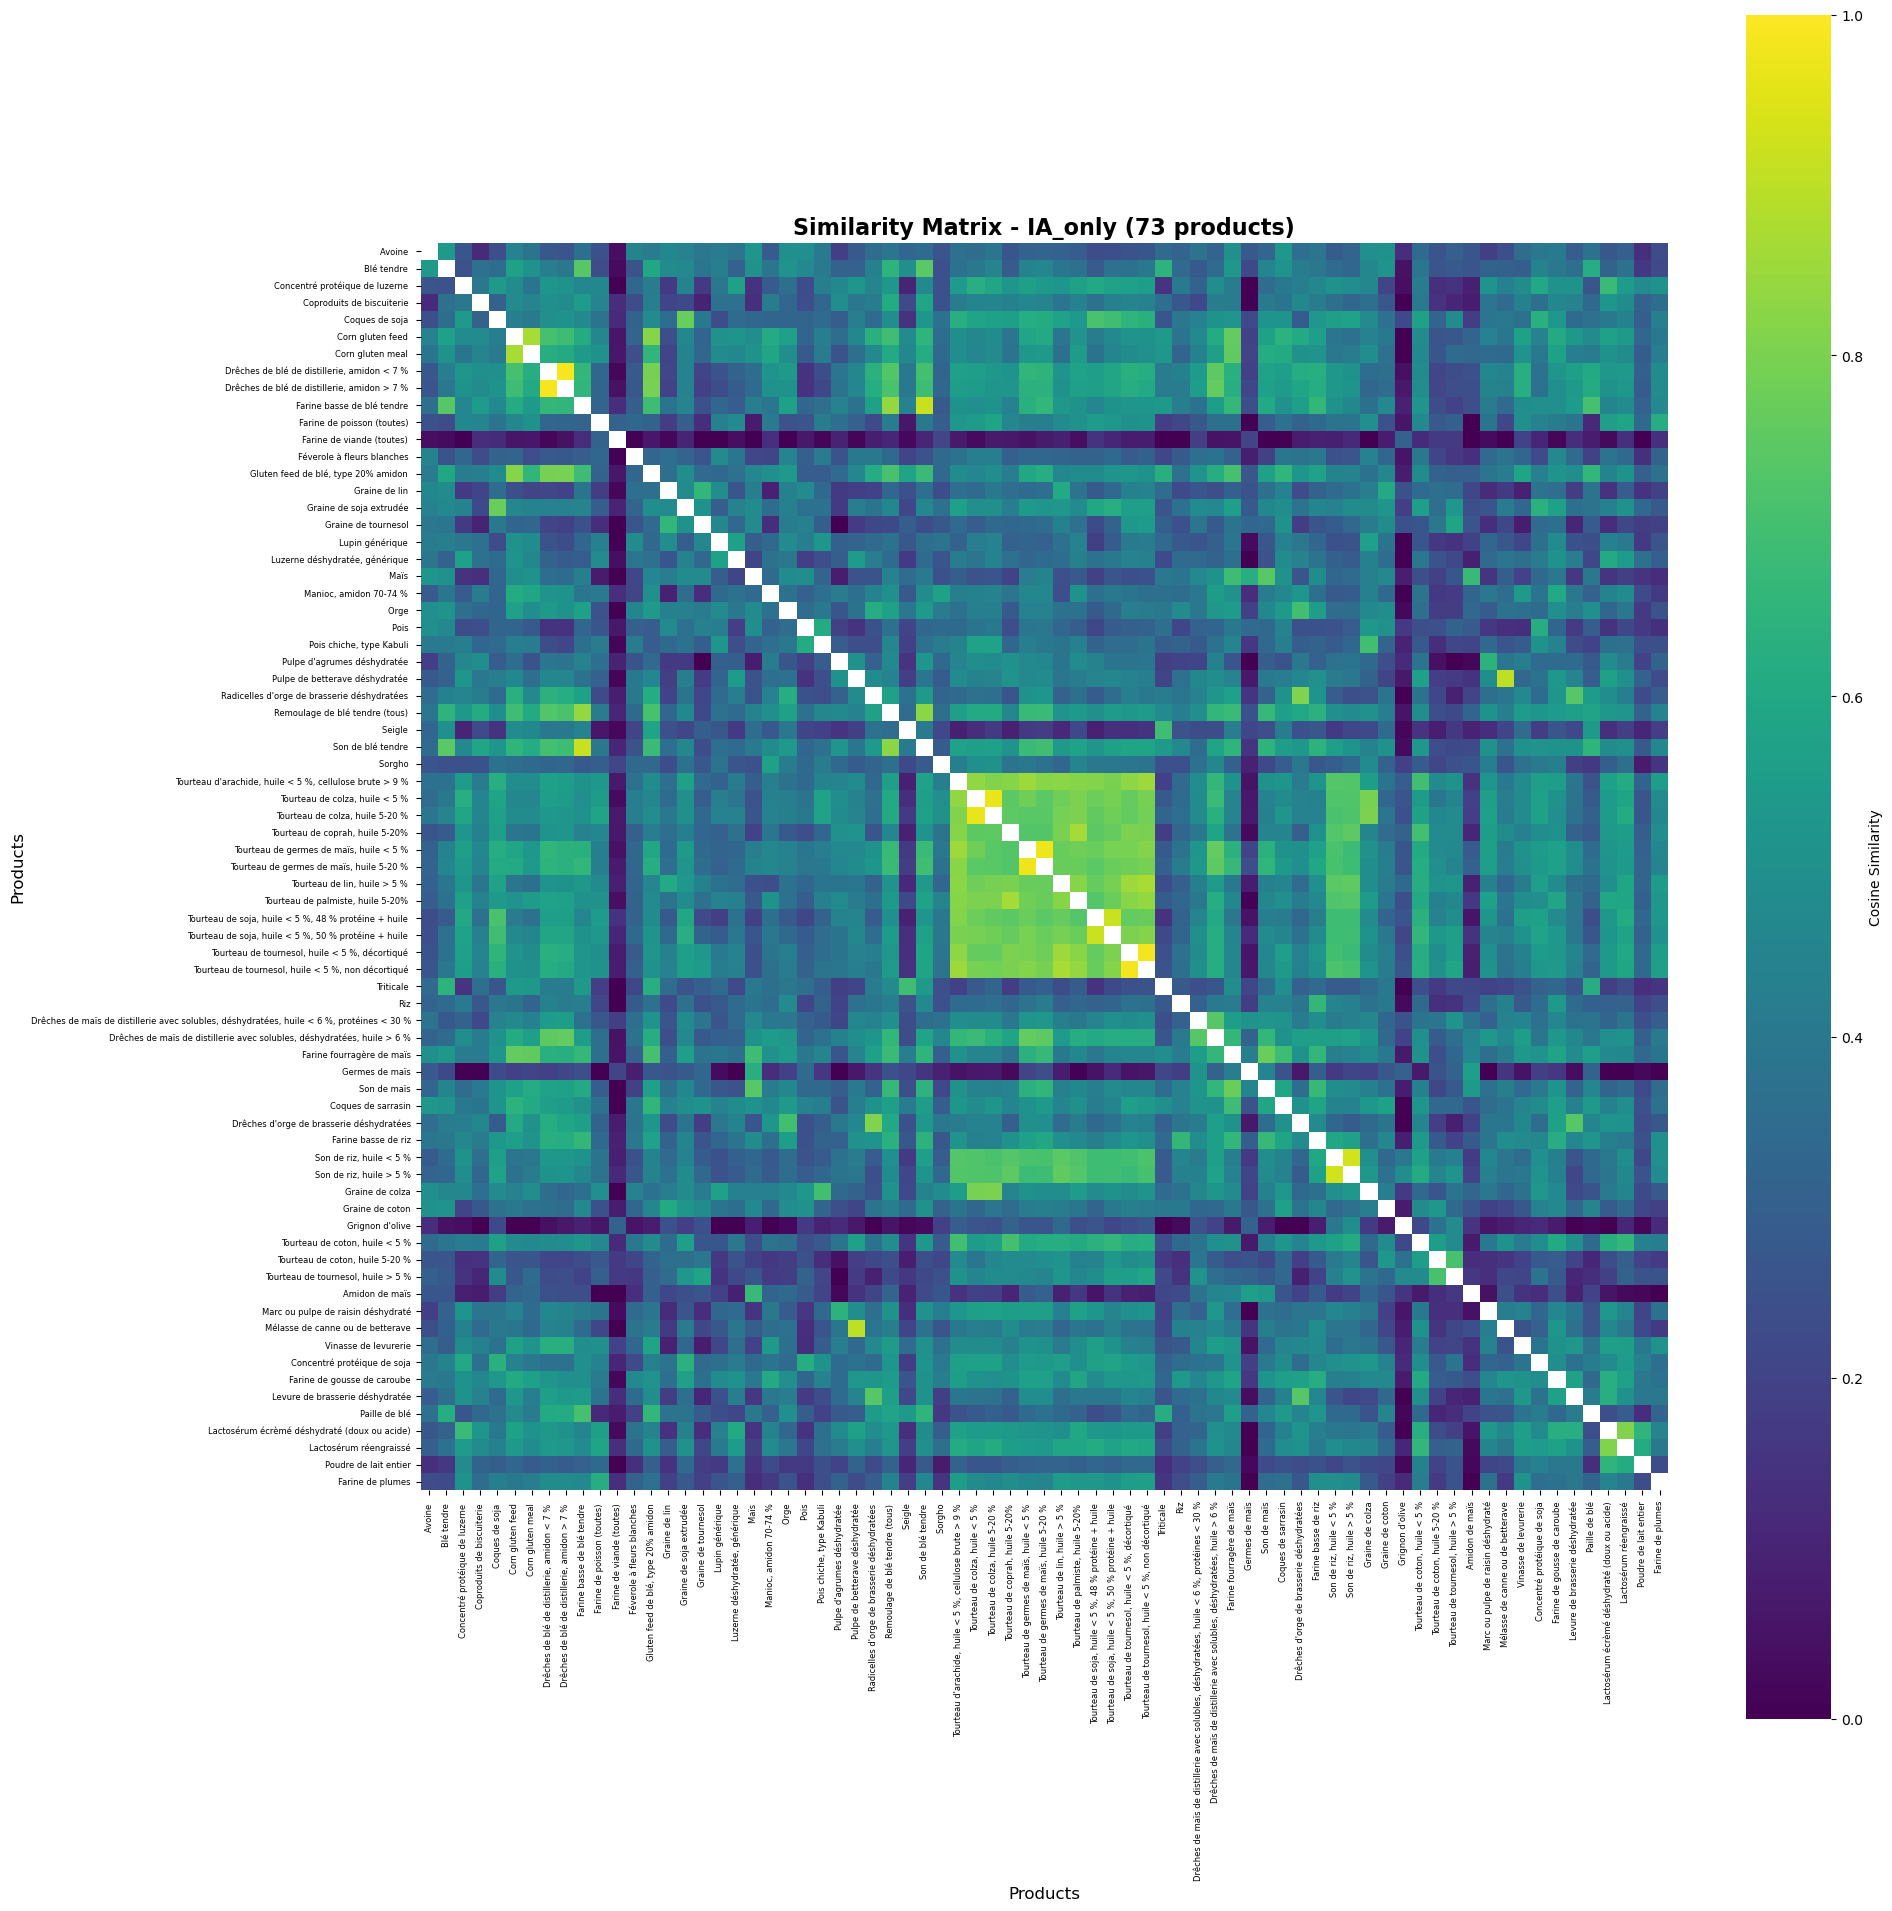


Feedtable_only - Similarity Matrix Heatmap


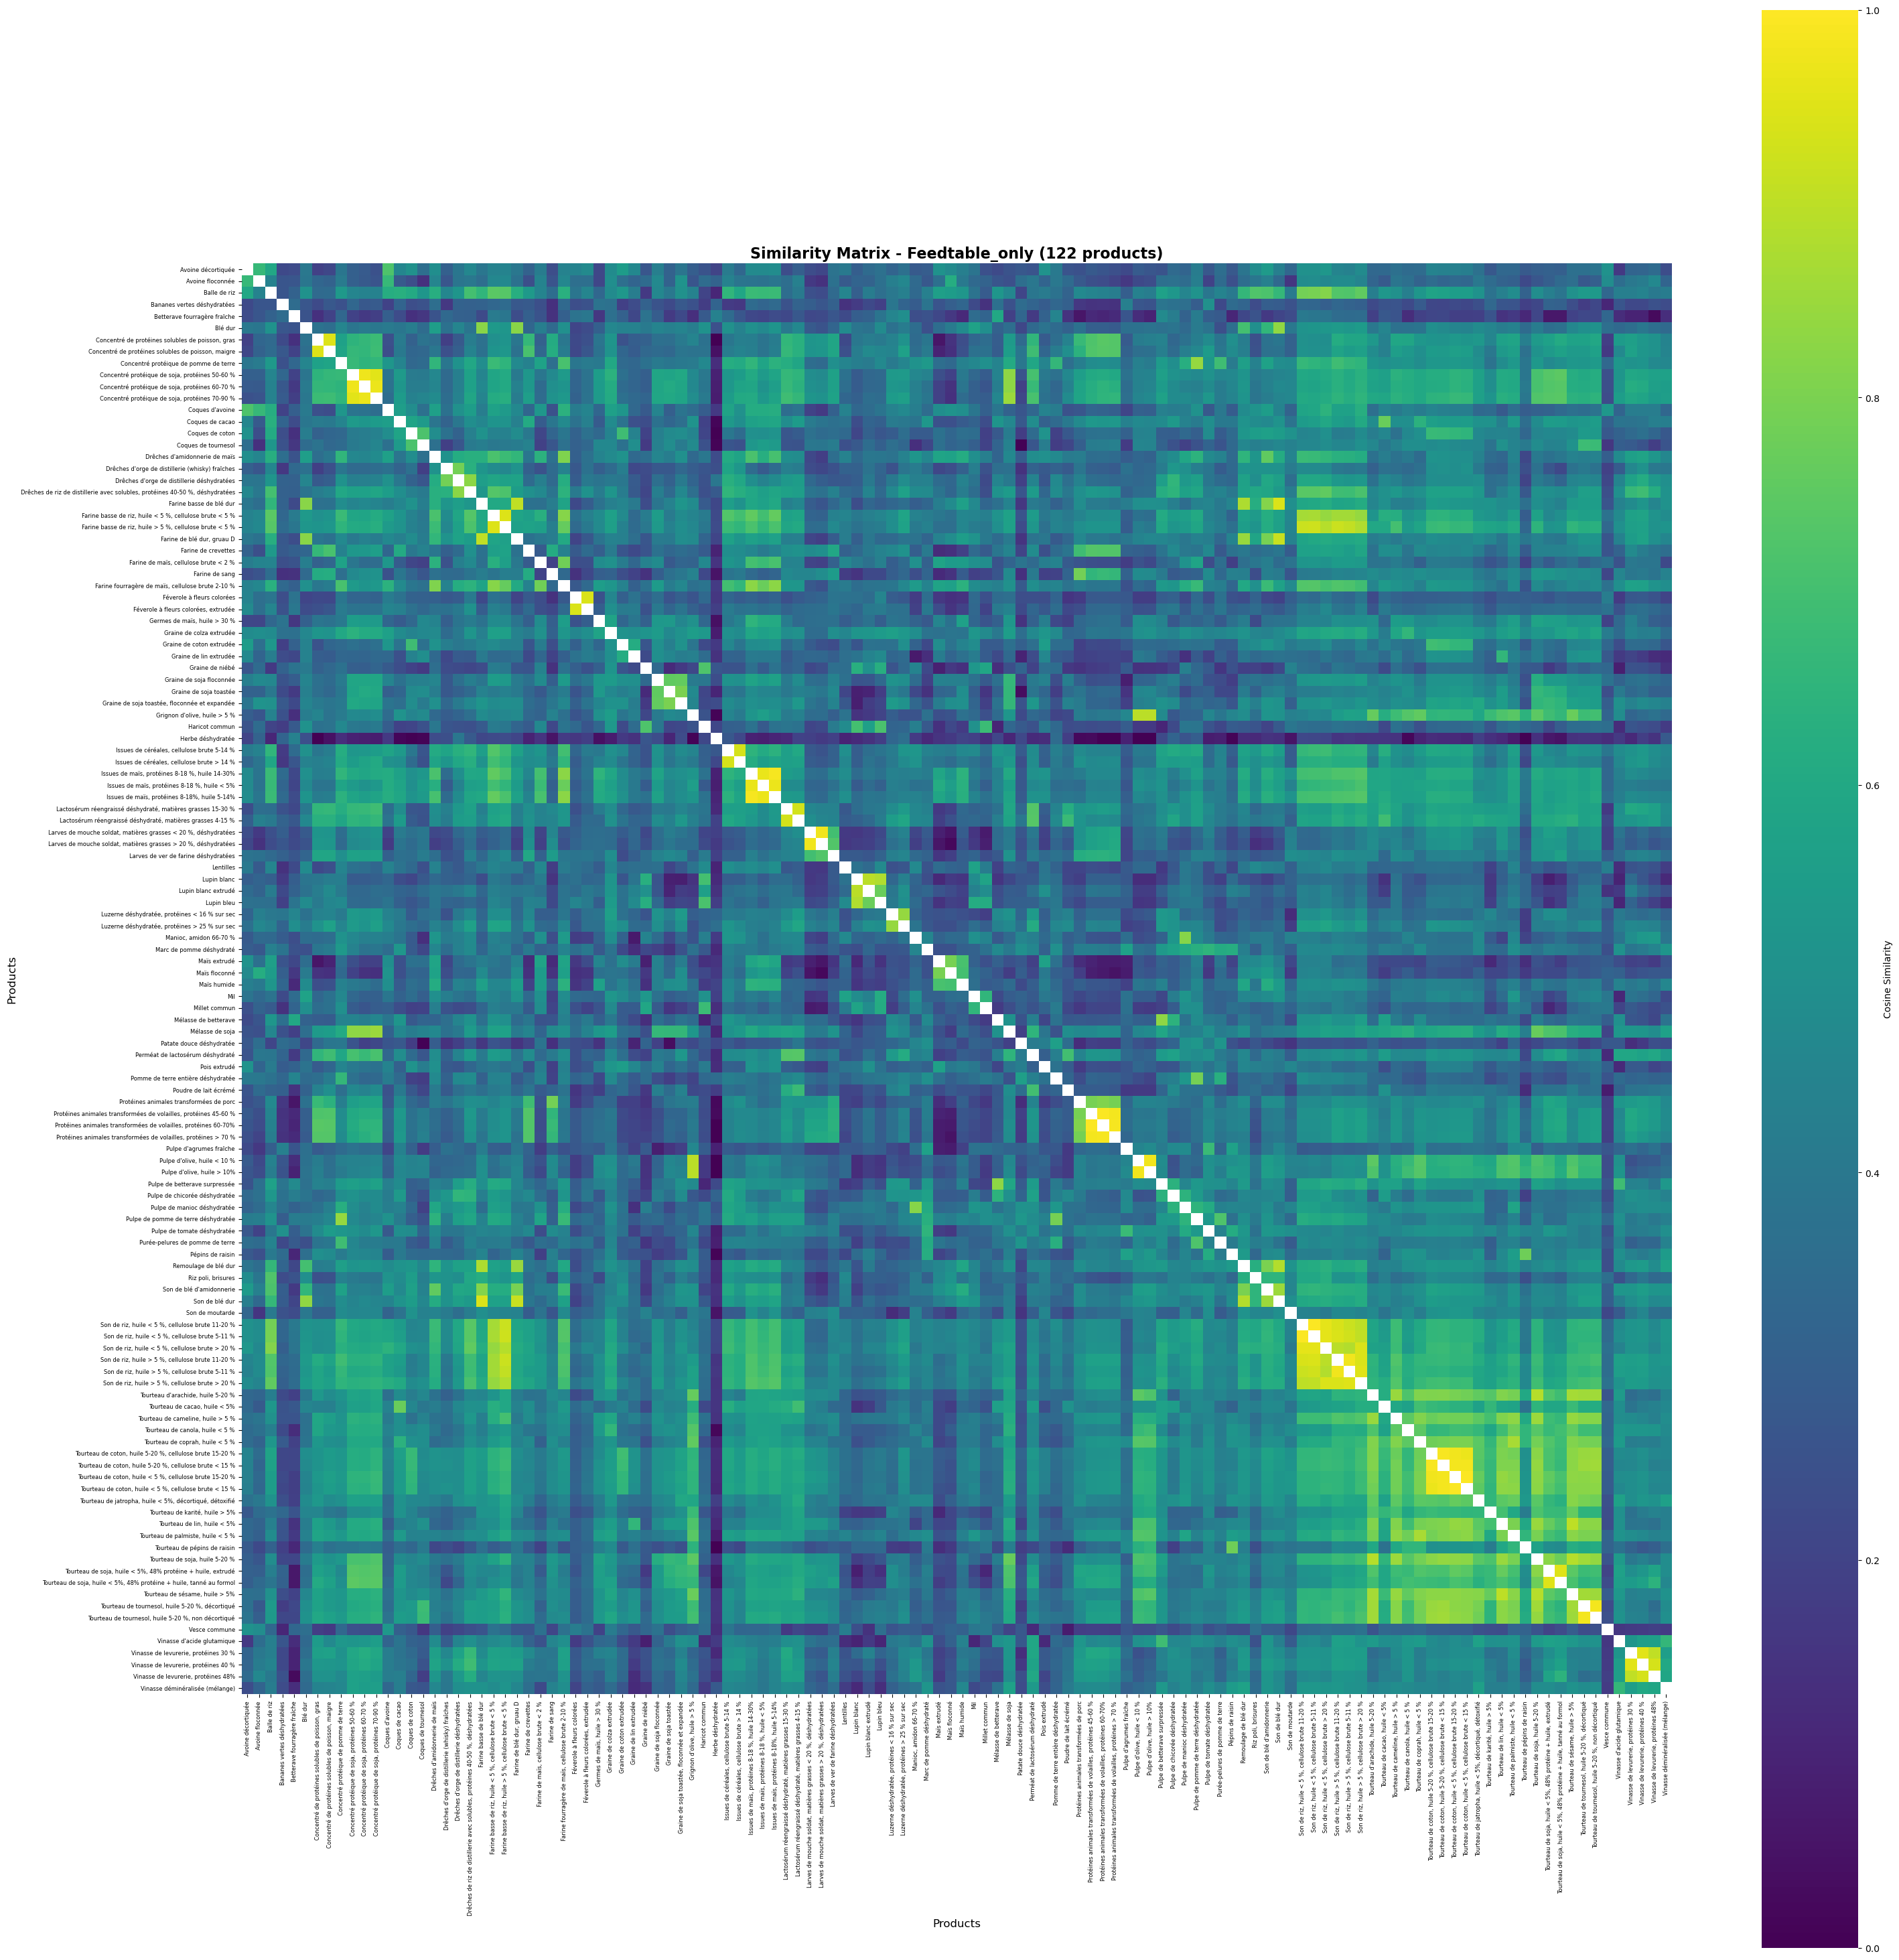


Combined - Similarity Matrix Heatmap


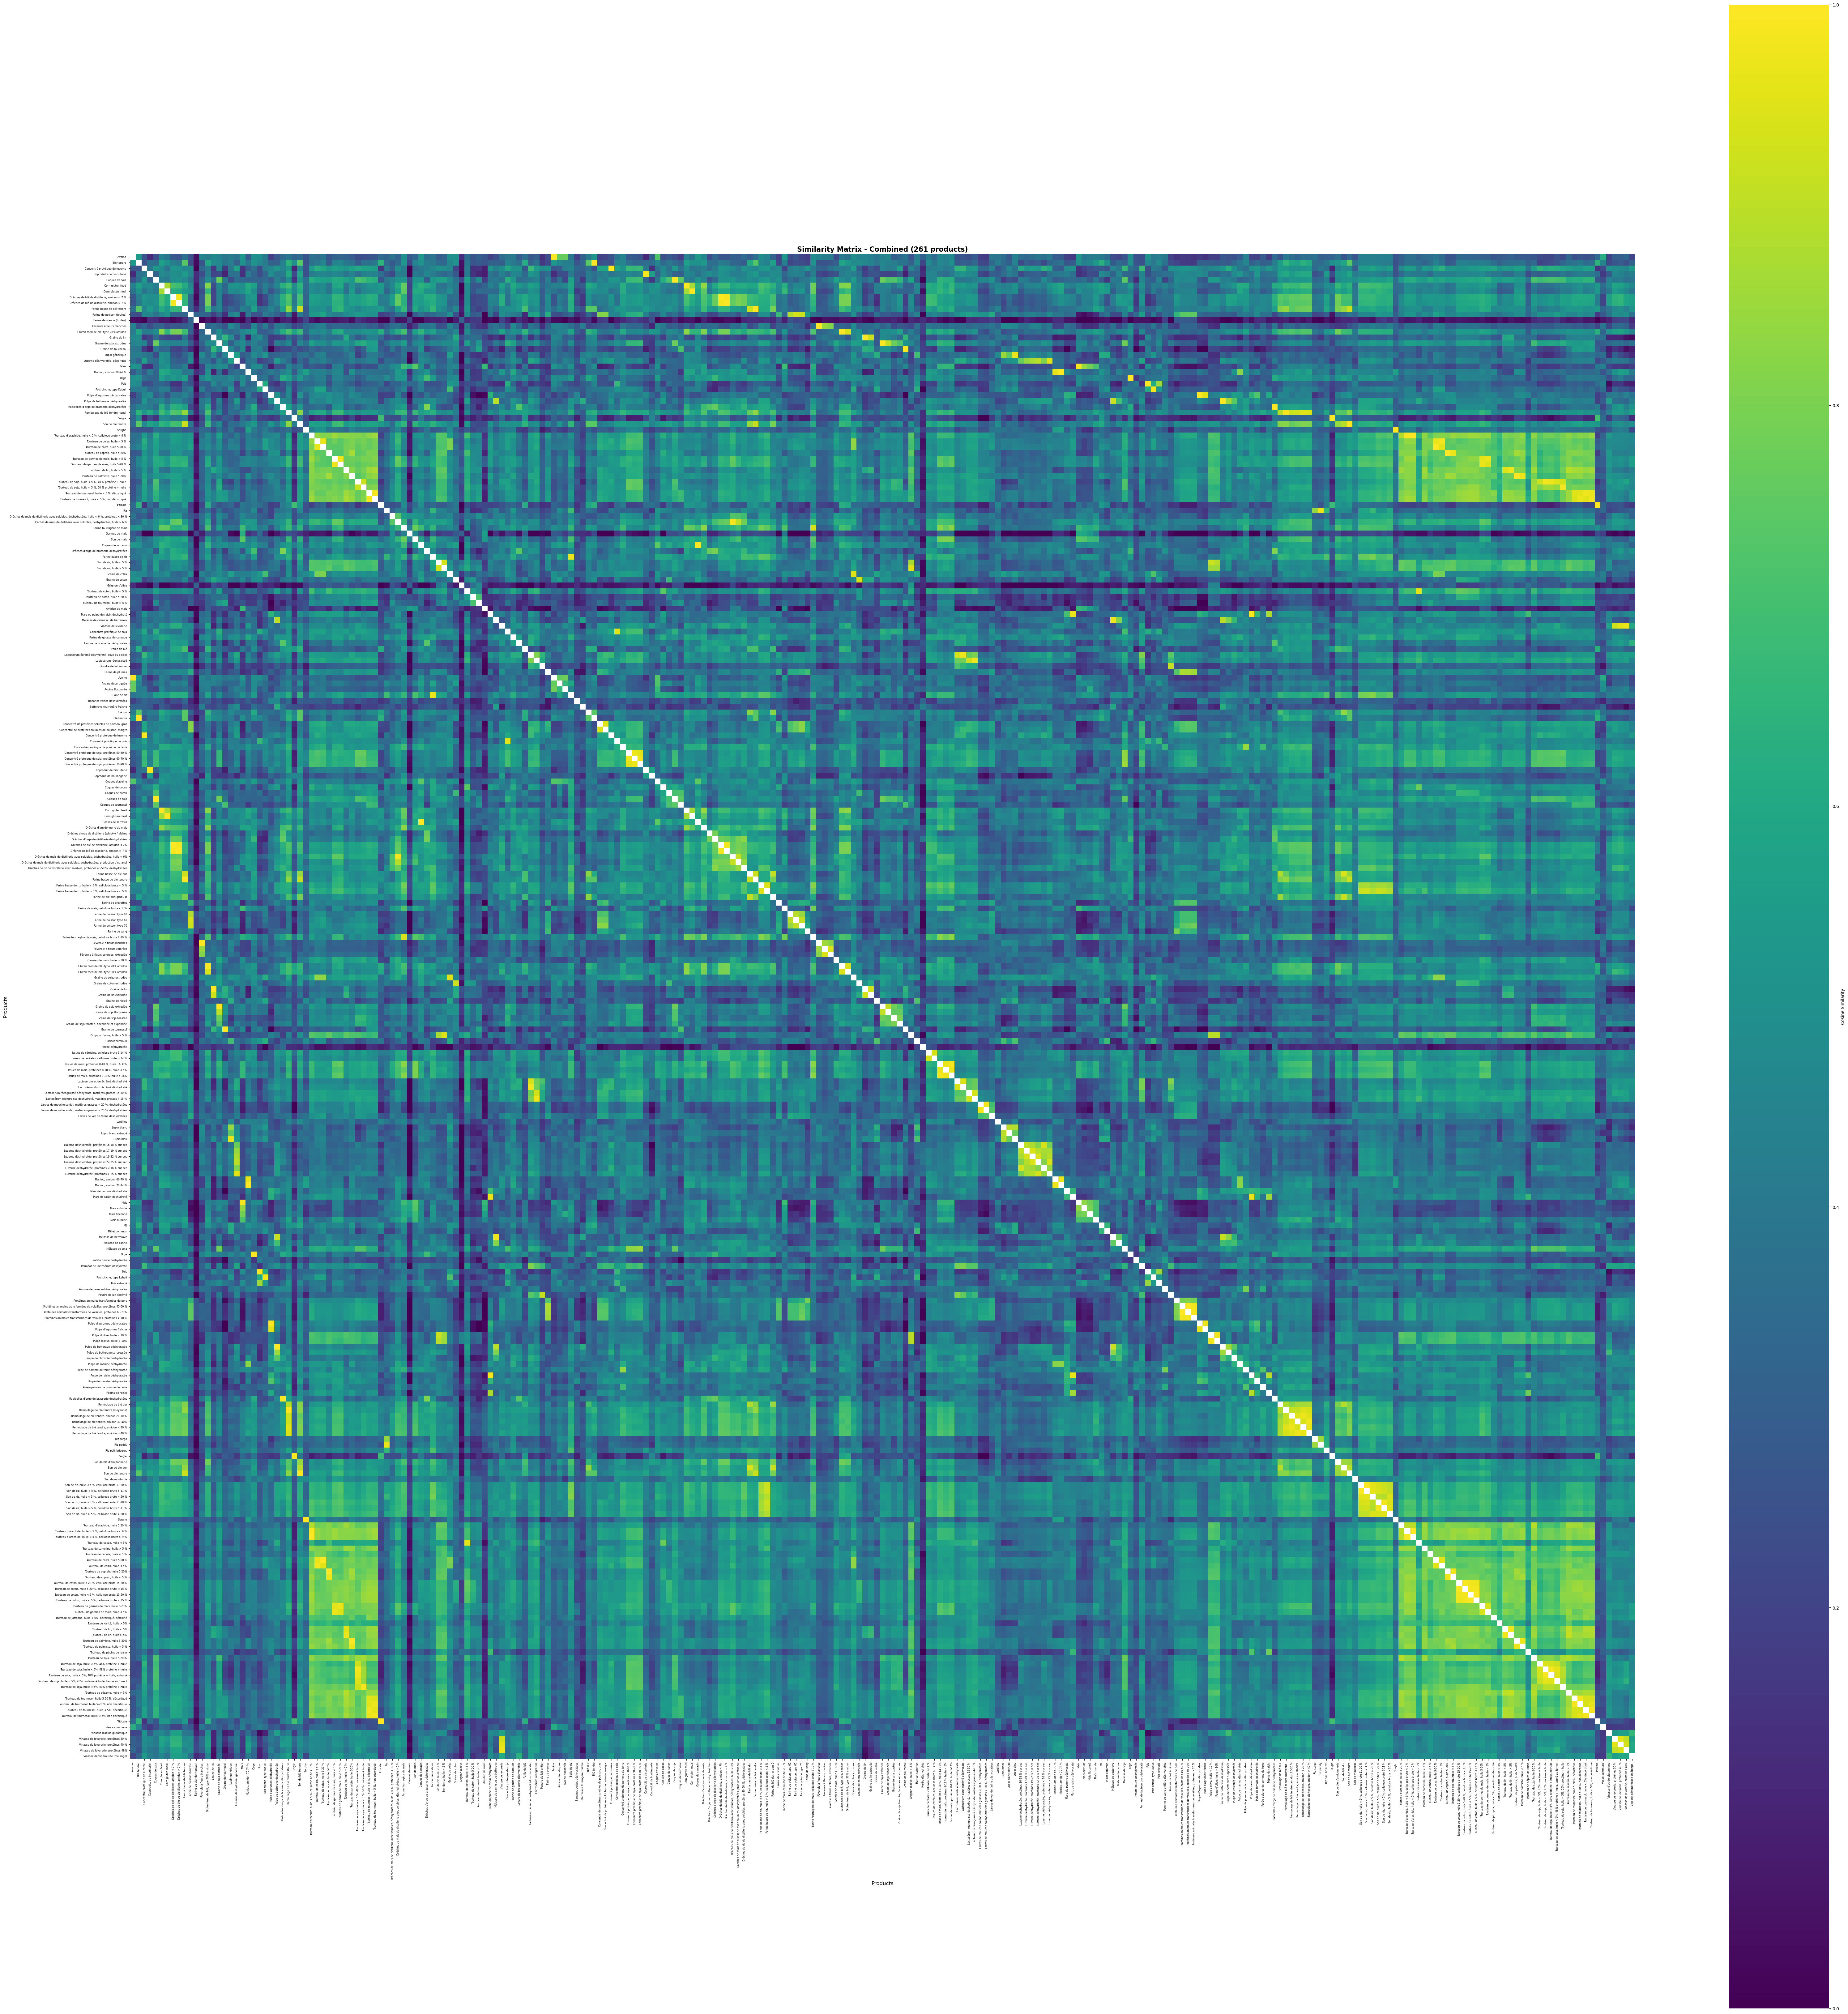

In [14]:
print("\n" + "="*80)
print("SIMILARITY MATRICES - HEATMAPS")
print("="*80)

for version_name, results in similarity_results.items():
    similarity_matrix = results['similarity_matrix']
    noms = results['noms']
    
    print(f"\n{'='*80}")
    print(f"{version_name} - Similarity Matrix Heatmap")
    print(f"{'='*80}")
    
    # Display all products
    heatmap_matrix = similarity_matrix
    heatmap_noms = noms
    
    # Adjust figure size based on number of products
    fig_size = max(20, len(noms) * 0.25)
    
    # Create heatmap
    plt.figure(figsize=(fig_size, fig_size))
    sns.heatmap(heatmap_matrix, xticklabels=heatmap_noms, yticklabels=heatmap_noms, 
                cmap='viridis', cbar_kws={'label': 'Cosine Similarity'},
                vmin=0, vmax=1, square=True, cbar=True)
    plt.title(f'Similarity Matrix - {version_name} ({len(noms)} products)', fontsize=16, fontweight='bold')
    plt.xlabel('Products', fontsize=12)
    plt.ylabel('Products', fontsize=12)
    plt.xticks(rotation=90, fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.show()

In [16]:
print("\n" + "="*80)
print("TOP 10 MOST SIMILAR PAIRS")
print("="*80)

pd.options.display.float_format = "{:.4f}".format

for version_name, results in similarity_results.items():
    print(f"\n{'='*80}")
    print(f"{version_name}")
    print(f"{'='*80}")
    
    top_10 = results['pairs_sorted'].head(10).reset_index(drop=True)
    
    display(top_10[['Nom_1', 'Nom_2', 'Similarity']])



TOP 10 MOST SIMILAR PAIRS

IA_only


Nom_1  \
0       Drêches de blé de distillerie, amidon < 7 %    
1    Tourteau de tournesol, huile < 5 %, décortiqué    
2           Tourteau de germes de maïs, huile < 5 %    
3                    Tourteau de colza, huile < 5 %    
4                            Son de riz, huile < 5 %   
5  Tourteau de soja, huile < 5 %, 48 % protéine +...   
6                        Farine basse de blé tendre    
7                    Pulpe de betterave déshydratée    
8                                  Corn gluten feed    
9                      Tourteau de lin, huile > 5 %    

                                               Nom_2  Similarity  
0       Drêches de blé de distillerie, amidon > 7 %       0.9853  
1  Tourteau de tournesol, huile < 5 %, non décort...      0.9812  
2          Tourteau de germes de maïs, huile 5-20 %       0.9751  
3                   Tourteau de colza, huile 5-20 %       0.9680  
4                            Son de riz, huile > 5 %      0.9299  
5  Tourteau de soja, huile < 5 %, 50 % protéine +...      0.9191  
6                                 Son de blé tendre       0.9143  
7                   Mélasse de canne ou de betterave      0.8986  
8                                  Corn gluten meal       0.8690  
9  Tourteau de tournesol, huile < 5 %, non décort...      0.8674


Feedtable_only


Nom_1  \
0   Son de riz, huile < 5 %, cellulose brute 11-20 %   
1  Tourteau de coton, huile < 5 %, cellulose brut...   
2  Protéines animales transformées de volailles, ...   
3  Tourteau de coton, huile 5-20 %, cellulose bru...   
4  Protéines animales transformées de volailles, ...   
5     Issues de maïs, protéines 8-18 %, huile 14-30%   
6  Tourteau de coton, huile 5-20 %, cellulose bru...   
7  Tourteau de coton, huile 5-20 %, cellulose bru...   
8  Protéines animales transformées de volailles, ...   
9    Tourteau de tournesol, huile 5-20 %, décortiqué   

                                               Nom_2  Similarity  
0    Son de riz, huile < 5 %, cellulose brute 5-11 %      0.9961  
1  Tourteau de coton, huile < 5 %, cellulose brut...      0.9938  
2  Protéines animales transformées de volailles, ...      0.9923  
3  Tourteau de coton, huile 5-20 %, cellulose bru...      0.9916  
4  Protéines animales transformées de volailles, ...      0.9882  
5       Issues de maïs, protéines 8-18%, huile 5-14%      0.9881  
6  Tourteau de coton, huile < 5 %, cellulose brut...      0.9815  
7  Tourteau de coton, huile < 5 %, cellulose brut...      0.9813  
8  Protéines animales transformées de volailles, ...      0.9807  
9  Tourteau de tournesol, huile 5-20 %, non décor...      0.9807


Combined


Nom_1  \
0       Drêches de blé de distillerie, amidon > 7 %    
1                    Concentré protéique de luzerne    
2                   Tourteau de colza, huile 5-20 %    
3                                  Corn gluten meal    
4  Tourteau d'arachide, huile < 5 %, cellulose br...   
5                        Farine basse de blé tendre    
6                                 Son de blé tendre    
7       Radicelles d'orge de brasserie déshydratées    
8                   Tourteau de coprah, huile 5-20%    
9                                  Corn gluten feed    

                                               Nom_2  Similarity  
0        Drêches de blé de distillerie, amidon > 7 %      0.9991  
1                     Concentré protéique de luzerne      0.9990  
2                    Tourteau de colza, huile 5-20 %      0.9989  
3                                   Corn gluten meal      0.9988  
4  Tourteau d'arachide, huile < 5 %, cellulose br...      0.9981  
5                         Farine basse de blé tendre      0.9979  
6                                  Son de blé tendre      0.9977  
7        Radicelles d'orge de brasserie déshydratées      0.9977  
8                    Tourteau de coprah, huile 5-20%      0.9975  
9                                   Corn gluten feed      0.9972

## 3. Analyse des Produits Isolés vs Connectés

Identifier les produits les plus isolés (faible similarité moyenne) et les plus connectés

In [17]:
print("\n" + "="*80)
print("TOP 5 MOST CONNECTED PRODUCTS (Highest Mean Similarity)")
print("="*80)

for version_name, results in similarity_results.items():
    mean_sim = results['mean_similarity']
    noms = results['noms']
    definitions = results['definitions']
    source = results['source']
    
    # Get indices of most similar products
    most_similar_idx = np.argsort(mean_sim)[::-1]  # Reverse pour descending
    
    print(f"\n{'='*80}")
    print(f"{version_name} - Top 5 Connected Products:")
    print(f"{'='*80}")
    
    for rank, idx in enumerate(most_similar_idx[:5], 1):
        print(f"\n{rank}. {noms[idx]}")
        print(f"   Mean Similarity: {mean_sim[idx]:.4f}")
        print(f"   Source: {source[idx]}")
        print(f"   Definition: {definitions[idx][:80]}...")



TOP 5 MOST CONNECTED PRODUCTS (Highest Mean Similarity)

IA_only - Top 5 Connected Products:

1. Tourteau de germes de maïs, huile 5-20 % 
   Mean Similarity: 0.5262
   Source: Donnees_IA
   Definition: Coproduit d'huilerie obtenu par l'extraction de l'huile de germes de maïs (Zea m...

2. Tourteau de germes de maïs, huile < 5 % 
   Mean Similarity: 0.5234
   Source: Donnees_IA
   Definition: Coproduit d'huilerie obtenu par l'extraction de l'huile de germes de maïs (Zea m...

3. Tourteau de colza, huile 5-20 % 
   Mean Similarity: 0.5055
   Source: Donnees_IA
   Definition: Coproduit d'huilerie obtenu par extraction de l'huile de graines de colza (Brass...

4. Tourteau de tournesol, huile < 5 %, non décortiqué 
   Mean Similarity: 0.5047
   Source: Donnees_IA
   Definition: Coproduit d'huilerie obtenu par extraction de l'huile de graines de tournesol (H...

5. Tourteau d'arachide, huile < 5 %, cellulose brute > 9 % 
   Mean Similarity: 0.5025
   Source: Donnees_IA
   Definition: Copro

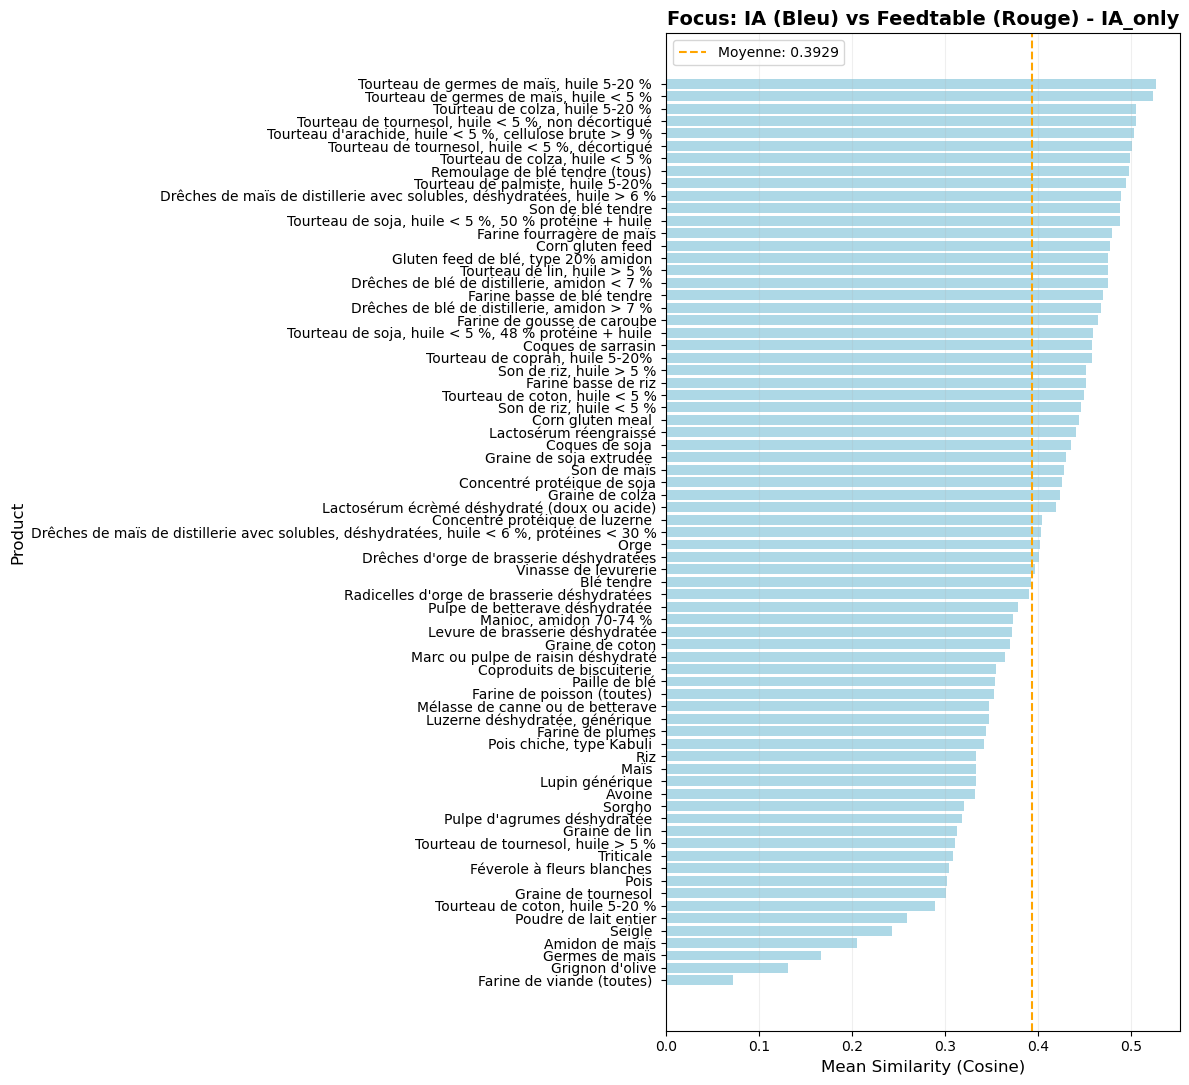

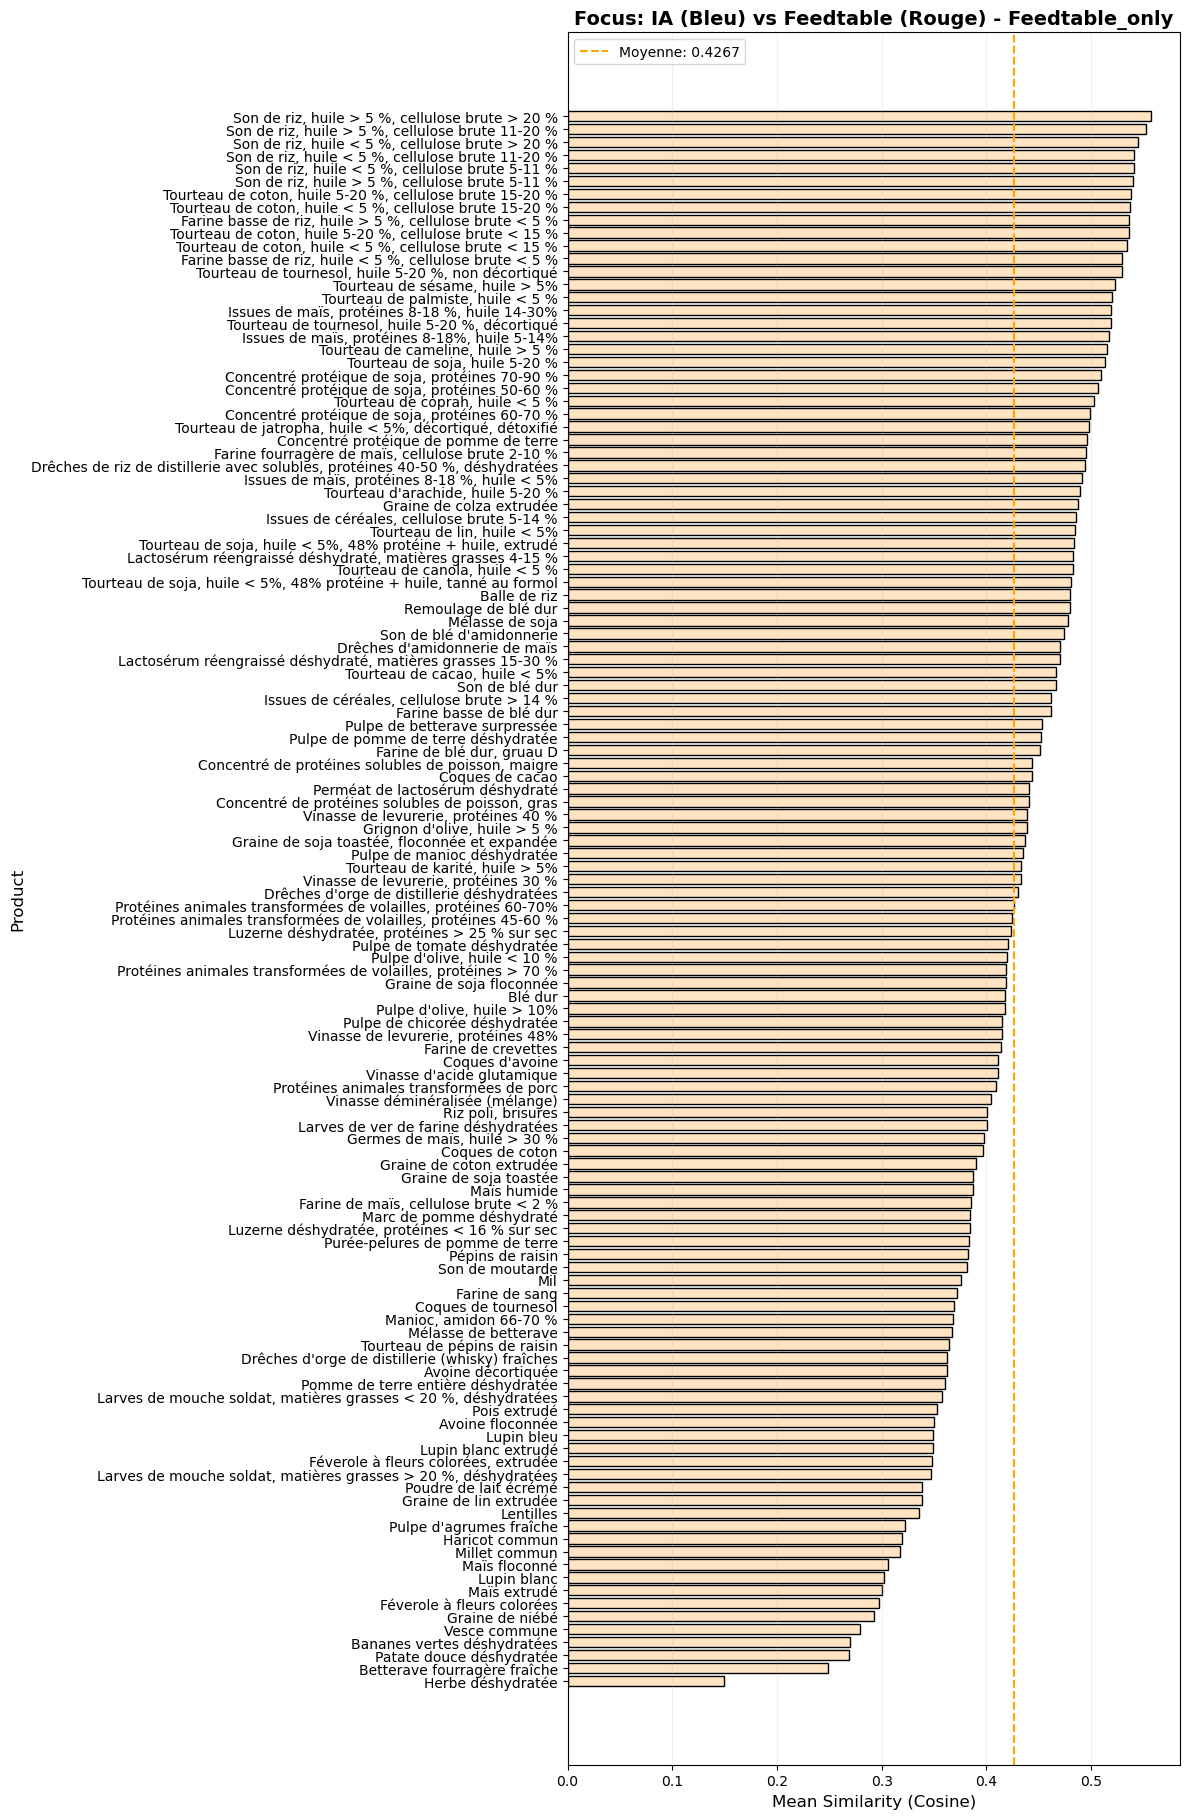

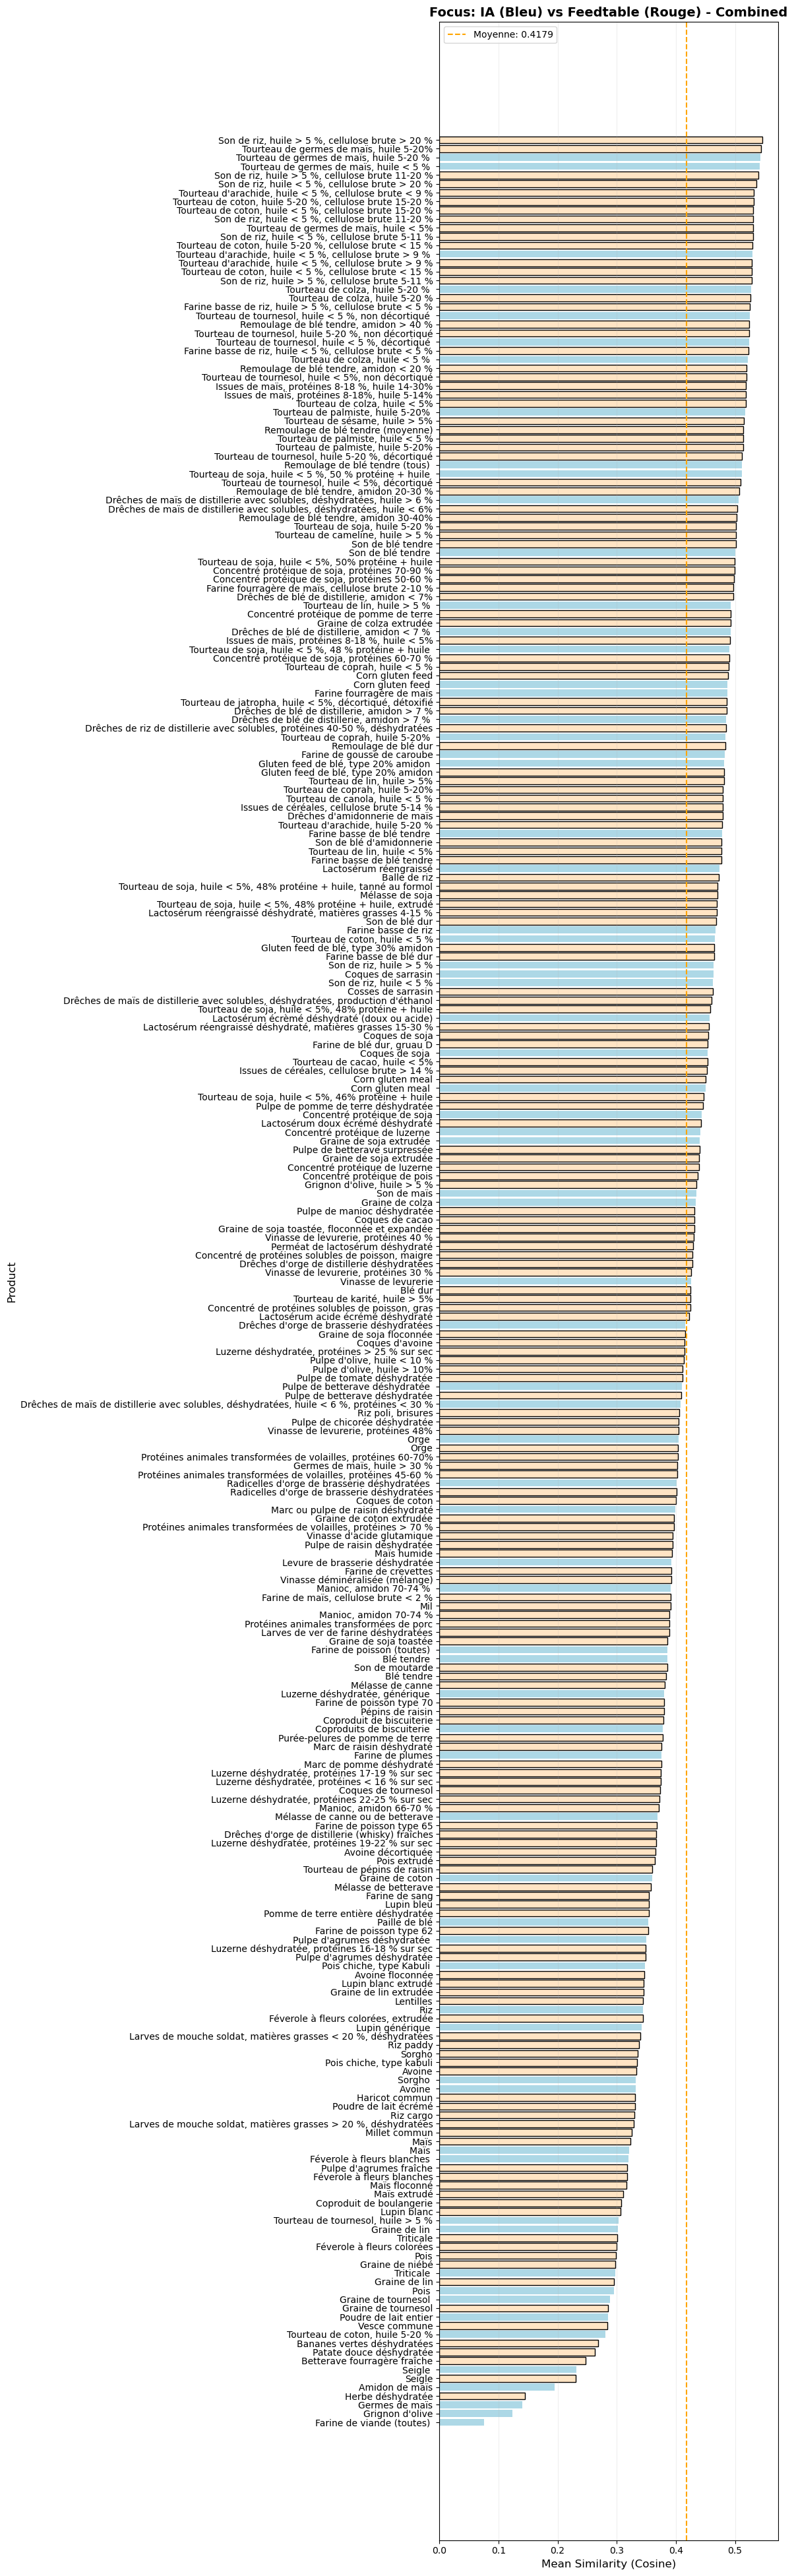

In [22]:
# Bar plots pour chaque version
for version_name, results in similarity_results.items():
    mean_sim = results['mean_similarity']
    noms = results['noms']
    sources = results['source']  # On récupère la liste des sources ici
    
    # On crée le DataFrame avec la source pour garder l'alignement après le tri
    similarity_df = pd.DataFrame({
        'Nom': noms,
        'Similarité Moyenne': mean_sim,
        'Source': sources
    }).sort_values('Similarité Moyenne', ascending=True)
    
    # Définition des couleurs basées sur la colonne 'Source'
    colors = []
    for src in similarity_df['Source']:
        if src == 'Donnees_IA':
            colors.append('lightblue')      # IA toujours en bleu
        elif src == 'Feedtable':
            colors.append('bisque')       # Feedtable toujours en rouge
        else:
            colors.append('lightgray') # Le reste en gris
    
    # Configuration du graphique
    plt.figure(figsize=(12, max(8, len(noms) * 0.15)))
    
    # On dessine les barres
    bars = plt.barh(similarity_df['Nom'], similarity_df['Similarité Moyenne'], color=colors)
    
    # Ajout d'une bordure noire pour les éléments colorés (IA et Feedtable)
    for i, src in enumerate(similarity_df['Source']):
        if src in ['Donnes_IA', 'Feedtable']:
            bars[i].set_edgecolor('black')
            bars[i].set_linewidth(1)

    plt.xlabel('Mean Similarity (Cosine)', fontsize=12)
    plt.ylabel('Product', fontsize=12)
    plt.title(f'Focus: IA (Bleu) vs Feedtable (Rouge) - {version_name}', fontsize=14, fontweight='bold')
    
    # Ligne de moyenne
    overall_mean = np.nanmean(mean_sim)
    plt.axvline(overall_mean, color='orange', linestyle='--', label=f'Moyenne: {overall_mean:.4f}')
    
    plt.legend()
    plt.grid(axis='x', alpha=0.2)
    plt.tight_layout()
    plt.show()